In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
import ProgressMeter
using LinearAlgebra
using WAV

In [2]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")
include("helpers/aida_ar.jl")
include("models/everything.jl")

LoadError: SystemError: opening file "/Users/apodusenko/Documents/Julia/AIDA/demo/helpers/aida_segmentation.jl": No such file or directory

In [3]:
# load bar sound
br, fs = wavread("sound/environment/bar.wav");
# load train sound
tr, fs = wavread("sound/environment/train.wav")
# load white noise
wn, fs = wavread("sound/environment/white_noise_1e-5.wav")

# load mixed
mx, fs, _ = wavread("sound/switching_context/bar_train_bar.wav")

([-0.0019226660969878231; -0.005615405743583483; … ; -0.0067445905941953795; -0.0025940733054597613], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x49, 0x6e, 0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a])])

In [4]:
mx

63357×1 Matrix{Float64}:
 -0.0019226660969878231
 -0.005615405743583483
  0.0005493331705679495
  0.0033875545518356883
  0.00445570238349559
  0.006042664876247444
  0.002075258644367809
 -0.0004272591326639607
  0.002685628833887753
  0.00173955504013184
  0.0008545182653279214
 -0.006378368480483413
 -0.01370281075472274
  ⋮
 -0.012512588885158849
 -0.015045625171666617
 -0.01718192083498642
 -0.015015106662190619
 -0.01281777397991882
 -0.004058961760307627
  0.0028077028717917417
  0.008728293710135197
  0.0017700735496078372
 -0.003936887722403638
 -0.0067445905941953795
 -0.0025940733054597613

In [5]:
br_seg = get_frames(br, fs)
tr_seg = get_frames(tr, fs)
wn_seg = get_frames(wn, fs)
mx_seg = get_frames(mx, fs)

1056×80 Matrix{Float64}:
 -0.00192267   -0.00561541    0.000549333  …  -0.0147404    -0.0122379
  0.00469985    0.0101016     0.00762963      -0.002472     -0.00601215
  0.000579852   0.000762963   0.00424207       0.0100101     0.00918607
 -0.00750755   -0.00341807   -0.0029603        0.0215766     0.0176397
  0.00219733    0.00134281    0.00497452      -0.00961333   -0.0152898
  0.00155644   -0.00103763   -0.00747703   …  -0.0125431    -0.00558489
 -0.000579852  -0.00119022    0.00289926      -0.00646992   -0.00613422
  0.00393689    0.00592059    0.00671407      -0.0044557    -0.00405896
 -0.0101932    -0.00457778   -0.00061037      -0.00701926   -0.0110172
  0.00744652    0.000366222  -0.00210578       0.0157476     0.0122074
 -0.0126347    -0.00555437   -0.00137333   …   0.0137638     0.0121158
 -0.00512711   -0.00408948   -0.00253304      -0.000793481   0.00476089
  0.00662252    0.00225837   -0.0036317        0.0143437     0.0162358
  ⋮                                        ⋱  

In [6]:
vmp_iter = 50
# totseg = 10
segments = mx_seg
totseg = size(segments, 1)
ar_order_1 = 2
ar_order_2 = 2

fe_br = zeros(totseg, vmp_iter)
fe_tr = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);
priors_ar_1 = Dict(:mθ => [1.25231,  -0.424707], 
                   :vθ =>Matrix{Float64}(I, ar_order_1, ar_order_1),
                   :aγ => 41.0, :bγ => 0.0005125367871437023)

priors_ar_2 = Dict(:mθ => [1.04507,  -0.197649], 
                   :vθ => Matrix{Float64}(I, ar_order_2, ar_order_2),
                   :aγ => 41.0, :bγ => 0.0012056489163429355)

ProgressMeter.@showprogress for segnum in 1:totseg
    γ, θ, xs, fe = lar_inference(segments[segnum, :], ar_order_1, vmp_iter, 1e-12, priors=priors_ar_1)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_br[segnum, :] = fe
    
    γ, θ, xs, fe = lar_inference(segments[segnum, :], ar_order_2, vmp_iter, 1e-12, priors=priors_ar_2)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_tr[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(segments[segnum, :], vmp_iter, 1e-12)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:13:08


In [10]:
lowest_fe = [findmin([x[end], y[end], z[end]])[2] for (x, y, z) in zip(eachrow(fe_br), eachrow(fe_tr), eachrow(fe_gaussian))]
findall(isequal(1), lowest_fe)

499-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
 1039
 1040
 1041
 1042
 1043
 1045
 1051
 1052
 1053
 1054
 1055
 1056

In [11]:
function model_posteriors(m_lh, m_pr)
    model_evidence = mapreduce(x -> x[1]*x[2], +, zip(m_lh, m_pr))
    posteriors = map(x -> x[1]*x[2], zip(m_lh, m_pr)) ./ model_evidence
end

model_posteriors (generic function with 1 method)

### Markov model

In [3]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples, Â, B̂; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = Â
    # Observation noise
    B = B̂
    # Initial state
    s_0 = zeros(size(A, 1)); s_0[1] = 1.0
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [4]:
function create_B(dims)
    base = ones(dims); base[1] = 1e2
    B = hcat(base)'
    for i in 1:dims-1
        base = circshift(base, 1)
        B = vcat(B, hcat(base)')
    end
    B
end

create_B (generic function with 1 method)

In [7]:
@model [ default_factorisation = MeanField() ] function hmm(n, order)
    
    A ~ MatrixDirichlet(ones(order, order)) 
    B ~ MatrixDirichlet(create_B(order))
    
    s_0 ~ Categorical(fill(1.0 / order, order))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

hmm (generic function with 1 method)

In [8]:
function inference_hmm(data, vmp_iter, order)
    n = length(data)
    
    model, (s, x, A, B) = hmm(n, order, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, order, order))
    setmarginal!(B, MatrixDirichlet(create_B(order)))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    ProgressMeter.@showprogress for i in 1:vmp_iter
        update!(x, data)
    end
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference_hmm (generic function with 1 method)

In [16]:
# classified based on FE
lowest_fe_vec = zeros(length(lowest_fe), 2)
for (index, l_fe) in enumerate(eachrow(lowest_fe_vec))
    l_fe[lowest_fe[index]] = 1.0
end

In [19]:
A = [0.5 0.5; 0.5 0.5] 
B = [0.5 0.5; 0.5 0.5] 
x_data = [lowest_fe_vec[i,:] for i in 1:size(lowest_fe_vec,1)]

1056-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 ⋮
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]

In [9]:
A = [0.7 0.3; 0.1 0.9] 
B = [1.0 0.0; 0.0 1.0] 
x_data, s_data = generate_data(100, A, B);

In [11]:
x_data = [[[1.0, 0.0] for _ in 1:25]; [[0.0, 1.0] for _ in 1:25]; [[1.0, 0.0] for _ in 1:25]; [[0.0, 1.0] for _ in 1:25]]

100-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 ⋮
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]

In [12]:
s, A, B, fe = inference_hmm(x_data, 100, 2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [13]:
A[end]

Marginal(MatrixDirichlet{Float64, Matrix{Float64}}(
a: [49.96706419514682 2.0324972998482993; 3.000584222194723 48.9998542828102]
)
)

In [15]:
mean(A[end])

2×2 Matrix{Float64}:
 0.943351   0.0398276
 0.0566494  0.960172

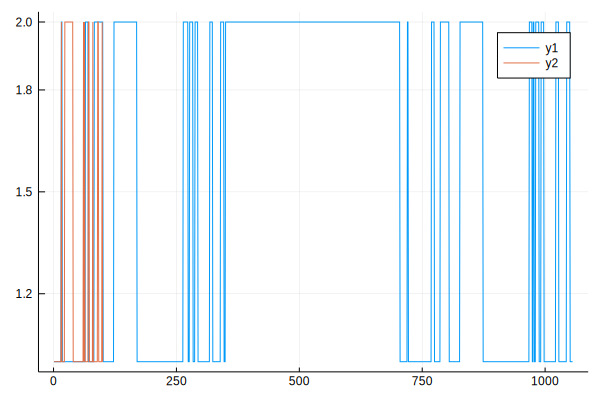

In [22]:
plot(round.(mean.(s[end])))
plot!(argmax.(s_data))

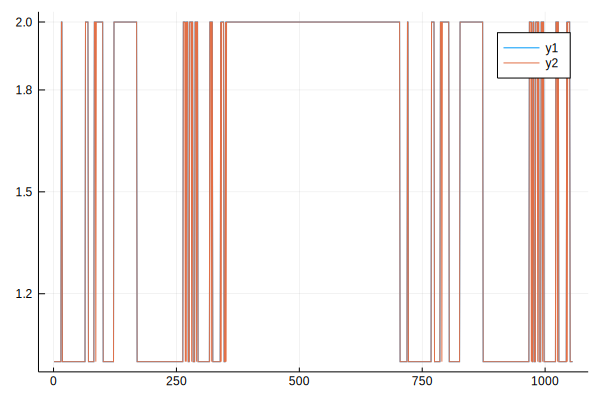

In [23]:
plot(round.(mean.(s[end])))
plot!(lowest_fe)